In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# manually add a2e-mmc repos to PYTHONPATH if needed
import os, sys
module_path = os.path.join('/home/ckaul/DriesNotebook')
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
from mmctools.plotting import plot_timehistory_at_height, plot_profile, plot_spectrum
from mmctools.helper_functions import calc_wind
import assessment.studies.coupling_comparison.helpers as helper

/home/ckaul/.conda-envs/my_env/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [5]:
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.labelsize']  = 16

# SWIFT coupling comparison: Data analysis (template)

Simulation name and directory, and name of virtual towers

In [8]:
simname = 'nalu_test' # This is output prefix
dpath = '/projects/mmcpnnl/ckaul/coupling/run/'
tower_filter = 'probe_profile2_0.dat'

In [9]:
tpathlist = glob.glob(os.path.join(dpath,tower_filter))
tpathlist.sort()
tpathlist

['/projects/mmcpnnl/ckaul/coupling/run/probe_profile2_0.dat']

Name of output files

In [10]:
results_dir = '/projects/mmcpnnl/ckaul/coupling/processedData'
output_tower0_10min   = os.path.join(results_dir,simname+'_tower0_10min.csv')
output_tower0_spectra = os.path.join(results_dir,simname+'_tower0_spectra.csv')
output_all_10min      = os.path.join(results_dir,simname+'_10min.csv')
output_all_spectra    = os.path.join(results_dir,simname+'_spectra.csv')

Heights and times at which spectra are computed. For each timestamp in `spectra_times`, the spectra will be computed for a period of `interval` starting at that timestamp with overlapping windows of size `window_size` (overlap of 50%). So with `interval = '1h'` and `window_size = '30min'`, each result will be the average of 3 overlapping windows.

In [11]:
spectra_heights = [10., 32., 80., 120.]
spectra_times = pd.date_range(start='2013-11-08 12:00:00',end='2013-11-09 11:00:00',freq='1h')
interval = '1h'
window_size = '30min'

Reference data 

In [12]:
#NetCDF file with WRF data at the SWiFT site generated in wrf_to_sowfa.ipynb, which can be found in
# a2e-mmc/assessment/studies/coupling_comparison/preprocessing/internal/
ref_dir = '/projects/mmcpnnl/ckaul/coupling/ReferenceData'
wrfdata = os.path.join(ref_dir,'WRF_20131108-09.nc')

# Datasets generated in process_TTU_tower.ipynb, which can be found in
# a2e-mmc/assessment/datasets/SWiFT/
towerdata_10min = os.path.join(ref_dir,'TTU_tilt_corrected_20131108-09_10min.csv')
towerdata       = os.path.join(ref_dir,'TTU_tilt_corrected_20131108-09.csv')

# Dataset generated in process_TTU_radar.ipynb, which can be found in
# a2e-mmc/assessment/datasets/SWiFT/
radardata = os.path.join(ref_dir,'TTU_obs_QC_20131108.csv')

# Part 1: Load, process and plot single virtual tower

## 1. Load virtual tower data

### 1a. Code-specific data loader

<font size=4><font color="red">**Define code-specific reader that returns a standardized pandas dataframe:**</font></font>

- multi-index dataframe with index levels `datetime` and `height`
- time axis is a `pd.DatetimeIndex`
- standard column names `u`, `v`, `w`, and `theta`
- standard SI units of [m], [m/s], and [K]

For example: use [NWTC/datatools/SOWFA6/postProcessing](https://github.com/NWTC/datatools/tree/master/SOWFA6/postProcessing) for reading in SOWFA output data

In [20]:
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#!!! SOWFA specific data reader, implement your own data reader as needed !!!
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
def reader(tpath):
    # Read in virtual tower data and convert to pandas DataFrame
    df = pd.read_csv(tpath, 
                     sep='\s+',
                     header=None,  
                     usecols=[0,3,4,5,6,7], 
                     names=['datetime','height','u','v','w','theta'],
                     dtype={'datetime':np.double, 'height':np.double, 'u':np.double, 'v':np.double, 'w':np.double, 'theta':np.double},
                     skiprows=[0])
    
    # Convert time in seconds to datetime
    df['datetime'] = pd.to_datetime(df['datetime'],unit='s', origin='2013-11-08 00:00:00')
    
    # Set multi-index with levels datetime and height
    df.set_index(['datetime','height'],inplace=True)
    return df

### 1b. Load data

In [21]:
%time df = reader(tpathlist[0])
df.head()
# CPU times: user 1min 42s, sys: 17.8 s, total: 2min
# Wall time: 2min 1s

CPU times: user 4min 14s, sys: 5.27 s, total: 4min 19s
Wall time: 3min 54s


u         v         w   theta
datetime                height                                      
2013-11-08 00:00:01.500 1950.0  9.930545  6.659055  0.031701  304.19
                        1940.0  9.900529  6.699038 -0.023910  304.15
                        1930.0  9.870536  6.749026  0.016913  304.10
                        1920.0  9.840538  6.799019 -0.011152  304.06
                        1910.0  9.800559  6.859042  0.006766  304.02

In [22]:
df.tail()

u         v         w      theta
datetime                height                                         
2013-11-08 23:02:44.500 40.0    4.803766  1.194724  0.020809  281.48820
                        30.0    4.325771  1.170468  0.052286  281.09738
                        20.0    3.847155  0.820339 -0.067520  280.83160
                        10.0    2.659441  0.694802  0.077244  280.61657
                        0.0     1.425479  0.271497 -0.079960  280.26801

ValueError: x and y must have same first dimension, but have shapes (165927,) and (169260,)

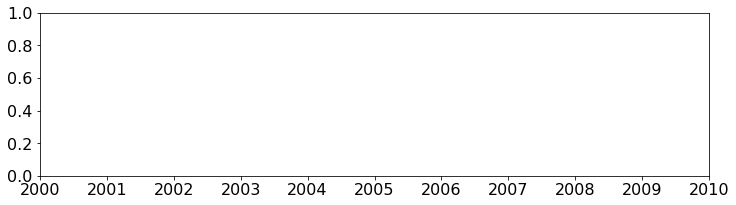

In [19]:
fig, ax = plot_timehistory_at_height(
    df,
    fields='theta',
    heights = df.index.levels[1][8]
)

## 2. Data processing

### 2a. 10-min statistics

In [16]:
%time df_10min = helper.calc_stats(df)
# CPU times: user 9.44 s, sys: 4.06 s, total: 13.5 s
# Wall time: 13.5 s

ValueError: Index contains duplicate entries, cannot reshape

In [ ]:
helper.calc_QOIs(df_10min)

In [ ]:
df_10min.head()

In [ ]:
%time df_10min.to_csv(output_tower0_10min)
# CPU times: user 740 ms, sys: 12 ms, total: 752 ms
# Wall time: 788 ms

### 2b. Turbulence spectra

In [17]:
# Compute windspeed and direction
df['wspd'], df['wdir'] = calc_wind(df)

In [18]:
# Interpolate to desired heights
%time df_hgt = helper.interpolate_to_heights(df,spectra_heights)
# CPU times: user 22.1 s, sys: 10.7 s, total: 32.8 s
# Wall time: 32.9 s

ValueError: Index contains duplicate entries, cannot reshape

In [ ]:
# Make sure data is equally spaced in time
%time df_hgt = helper.reindex_if_needed(df_hgt)
# CPU times: user 417 ms, sys: 1.83 ms, total: 419 ms
# Wall time: 419 ms

In [ ]:
# Compute spectra
%time 
df_spectra = helper.calc_spectra(df_hgt,spectra_times,spectra_heights,interval,window_size)
df_spectra.head()
# CPU times: user 2.87 s, sys: 9.46 ms, total: 2.88 s
# Wall time: 2.89 s

In [ ]:
%time df_spectra.to_csv(output_tower0_spectra)
# CPU times: user 2.01 s, sys: 24.7 ms, total: 2.03 s
# Wall time: 2.1 s

## 3. Reference data

In [ ]:
wrf = helper.load_wrf_reference_data(wrfdata)

In [ ]:
radar_scan0, radar_scan1 = helper.load_radar_reference_data(radardata)

In [ ]:
%%time
tower_10min = helper.load_tower_reference_data(towerdata_10min)
tower_spectra = helper.load_tower_reference_spectra(towerdata,
                                                    spectra_times,spectra_heights,
                                                    interval,window_size)
# CPU times: user 13 s, sys: 724 ms, total: 13.7 s
# Wall time: 13.7 s

## 4. Plot virtual tower data

In [ ]:
fig,ax,ax2 = plot_timehistory_at_height(
    datasets={simname:df_10min,'WRF mesoscale':wrf,'TTU tower':tower_10min},
    fields = ['wspd','wdir','theta','TKE'],
    heights = 80,
    # Specify time limits
    timelimits=('2013-11-08 12:00:00','2013-11-09 12:00:00'),
    # plot local time
    plot_local_time=True,
    local_time_offset=-6,
    # Additional keyword arguments to personalize plotting style
    linewidth=2,linestyle='-',marker=None,
)

#Move xs tick down slightly to avoid overlap with y ticks in ax[1]
ax[-1].tick_params(axis='x', which='minor', pad=10)

# Adjust xaxis tick locations
ax2.xaxis.set_major_locator(mpl.dates.AutoDateLocator(minticks=2,maxticks=3))

In [ ]:
df_1h = df_10min.unstack().resample('1h').mean().stack()
tower_1h = tower_10min.unstack().resample('1h').mean().stack()
radar_scan0_1h = radar_scan0.unstack().resample('1h').mean().stack()
radar_scan1_1h = radar_scan1.unstack().resample('1h').mean().stack()
wrf_1h = wrf.unstack().resample('1h').mean().stack()

In [ ]:
fig,ax = plot_profile(
    datasets={simname:df_1h,
              'WRF mesoscale':wrf_1h,
              'TTU tower':tower_1h,
              'TTU radar (scan type 0)':radar_scan0_1h,
              'TTU radar (scan type 1)':radar_scan1_1h},
    fields=['wspd','wdir','theta','TKE'],
    times=['2013-11-08 18:00:00','2013-11-08 22:00:00','2013-11-09 06:00:00'],
    # Specify height limits
    heightlimits=(0,1200),
    # Stack results by dataset instead of times
    stack_by_datasets=True,
    # Change field order to have different fields correspond to different columns instead of rows
    fieldorder='F',
    datasetkwargs={'TTU tower':{'linestyle':'','marker':'o','mfc':'none','markersize':6},
                   'TTU radar (scan type 0)':{'linestyle':'','marker':'x','mfc':'none','markersize':6},
                   'TTU radar (scan type 1)':{'linestyle':'','marker':'^','mfc':'none','markersize':6}
                  },
    # Additional keyword arguments to personalize plotting style
    linewidth=2,
)

In [ ]:
fig,ax = plot_spectrum(
    datasets={simname:df_spectra,'TTU observations':tower_spectra},
    height=80,
    times=['2013-11-08 18:00:00','2013-11-08 22:00:00','2013-11-09 06:00:00'],
    fields=['wspd','w','theta'],
    freqlimits=(0.0003,0.3),
    fieldlimits={'wspd':(1.0e-5,1.0e3),'w':(1.0e-5,1.0e2),'theta':(1.0e-5,1.0e2)},
)

# Part 2: Load, process, average and save all virtual tower data

In [ ]:
%%time
df_10min = []
df_spectra = []
for towerID, tpath in enumerate(tpathlist):
    print('Reading '+tpath)
    try:
        # 1. Read tower
        dfi = reader(tpath)
        
        # 2. Calculate statistics
        dfi_10min = helper.calc_stats(dfi)
        dfi_10min['towerID'] = towerID
        
        # 3. Calculate spectra
        # - compute wspd and wdir so that corresponding spectra are calculated as well
        dfi['wspd'],dfi['wdir'] = calc_wind(dfi)
        # - interpolate to specific heights
        dfi_hgt = helper.interpolate_to_heights(dfi,spectra_heights)
        # - reindex if some timestamps are missing
        dfi_hgt = helper.reindex_if_needed(dfi_hgt)
        # - calculate spectra at specific times
        dfi_spectra = helper.calc_spectra(dfi_hgt,spectra_times,spectra_heights,interval,window_size)
        dfi_spectra['towerID'] = towerID
    except (IOError, UnicodeDecodeError, AssertionError, ValueError) as err:
        print(err,'while reading',tpath)
    
    # Append to list
    df_10min.append(dfi_10min)
    df_spectra.append(dfi_spectra)
    
df_10min = pd.concat(df_10min)
df_10min.set_index('towerID',append=True,inplace=True)

df_spectra = pd.concat(df_spectra)
df_spectra.set_index('towerID',append=True,inplace=True)

# CPU times: user 20min 31s, sys: 3min 2s, total: 23min 34s
# Wall time: 23min 48s

In [ ]:
df_10min.head(n=10)

In [ ]:
df_spectra.head(n=10)

Average over all the towers

In [ ]:
df_10min = df_10min.unstack(level=['datetime','height']).mean(axis=0).unstack(level=0)

In [ ]:
%time df_10min.to_csv(output_all_10min)
# CPU times: user 537 ms, sys: 7.96 ms, total: 545 ms
# Wall time: 576 ms

In [ ]:
df_spectra = df_spectra.unstack(level=['datetime','height','frequency']).mean(axis=0).unstack(level=0)

In [ ]:
%time df_spectra.to_csv(output_all_spectra)
# CPU times: user 2.05 s, sys: 29 ms, total: 2.08 s
# Wall time: 2.16 s